<a href="https://colab.research.google.com/github/LucienCastle/diabetes-patient-readmission-prediction/blob/main/Readmission_Prediction_AutoML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip uninstall -y Cython scipy pyparsing scikit_learn imbalanced-learn mlxtend yellowbrick
!pip install Cython==0.29.36 scipy==1.9 pyparsing==2.4
!pip install scikit-learn==0.24.2 --no-build-isolation
!pip install auto-sklearn
!pip install -f http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html h2o

Found existing installation: Cython 3.0.4
Uninstalling Cython-3.0.4:
  Successfully uninstalled Cython-3.0.4
Found existing installation: scipy 1.11.3
Uninstalling scipy-1.11.3:
  Successfully uninstalled scipy-1.11.3
Found existing installation: pyparsing 3.1.1
Uninstalling pyparsing-3.1.1:
  Successfully uninstalled pyparsing-3.1.1
Found existing installation: scikit-learn 1.2.2
Uninstalling scikit-learn-1.2.2:
  Successfully uninstalled scikit-learn-1.2.2
Found existing installation: imbalanced-learn 0.10.1
Uninstalling imbalanced-learn-0.10.1:
  Successfully uninstalled imbalanced-learn-0.10.1
Found existing installation: mlxtend 0.22.0
Uninstalling mlxtend-0.22.0:
  Successfully uninstalled mlxtend-0.22.0
Found existing installation: yellowbrick 1.5
Uninstalling yellowbrick-1.5:
  Successfully uninstalled yellowbrick-1.5
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 26.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 MB 19.0 MB/s eta 0:00:00
  

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 81.7 MB/s eta 0:00:00
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-learn: filename=scikit_learn-0.24.2-cp310-cp310-linux_x86_64.whl size=22232001 sha256=963515f15f42766b98b3281ec4a72014a8d3d3ba06d121b789fe4b9d4e3d2e3b
  Stored in directory: /root/.cache/pip/wheels/13/a4/68/4e78865652fa14db4a162b491e5138565f97646f9e1f2ab8cc
Successfully built scikit-learn
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 0.10.0 requires scikit-learn>=1.2.2, but you have scikit-learn 0.24.2 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 11.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━

In [1]:
from __future__ import annotations
from pprint import pprint
from io import BytesIO
from sklearn.preprocessing import StandardScaler

import pickle
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics
import autosklearn.classification
import h2o

from h2o.automl import H2OAutoML
from ConfigSpace.configuration_space import ConfigurationSpace
from autosklearn.askl_typing import FEAT_TYPE_TYPE
from autosklearn.pipeline.components.base import AutoSklearnPreprocessingAlgorithm
from autosklearn.pipeline.constants import SPARSE, DENSE, UNSIGNED_DATA, INPUT
from smac.optimizer.smbo import SMBO
from smac.runhistory.runhistory import RunInfo, RunValue

In [2]:
df_train = pd.read_parquet('data/df_train.gzip')
df_valid = pd.read_parquet('data/df_valid.gzip')
df_test = pd.read_parquet('data/df_test.gzip')

In [3]:
X_train = df_train.iloc[:, :-1]
X_valid = df_valid.iloc[:, :-1]

y_train = df_train.iloc[:,-1]
y_valid = df_valid.iloc[:, -1]

print('Training shapes:',X_train.shape, y_train.shape)
print('Validation shapes:',X_valid.shape, y_valid.shape)

Training shapes: (15766, 143) (15766,)
Validation shapes: (14901, 143) (14901,)


In [26]:
from pandas.core.arrays import boolean
def callback(
    smbo: SMBO,
    run_info: RunInfo,
    result: RunValue,
    time_left: float,
) -> bool | None:
    """Stop early if we get a very low cost value for a single run

    The return value indicates to SMAC whether to stop or not. False will
    stop the search process while any other value will mean it continues.
    """
    # You can find out the parameters in the SMAC documentation
    # https://automl.github.io/SMAC3/main/
    if result.cost <= 0.01:
        print("Stopping!")
        print(run_info)
        print(result)
        return False

def show_statistics(
    automl,
    show_models: bool=False
) -> None:
    print('---------------------------Leaderboard--------------------------------')
    print(automl.leaderboard())
    print('\n---------------------------Statistics---------------------------------')
    print(automl.sprint_statistics())
    losses_and_configurations = [
        (run_value.cost, run_key.config_id)
        for run_key, run_value in automl.automl_.runhistory_.data.items()
    ]
    losses_and_configurations.sort()
    print("Lowest loss:", losses_and_configurations[0][0])
    print(
        "\nBest configuration:",
        automl.automl_.runhistory_.ids_config[losses_and_configurations[0][1]],
    )

    if show_models:
      print('\n--------------------------Models-----------------------------------')
      pprint(automl.show_models(), indent=4)

In [15]:
automl = autosklearn.classification.AutoSklearnClassifier(
    time_left_for_this_task=200,
    per_run_time_limit=60,
    get_trials_callback=callback,
    metric=autosklearn.metrics.accuracy,
    exclude=None
)

automl.fit(X_train, y_train, X_valid, y_valid, dataset_name='patient-readmission')

AutoSklearnClassifier(ensemble_class=<class 'autosklearn.ensembles.ensemble_selection.EnsembleSelection'>,
                      get_trials_callback=<function callback at 0x7cd7f6f82b90>,
                      metric=accuracy, per_run_time_limit=60,
                      time_left_for_this_task=200)

In [16]:
show_statistics(automl)

---------------------------Leaderboard--------------------------------
          rank  ensemble_weight               type      cost   duration
model_id                                                               
18           1             0.24                lda  0.376321   1.480597
3            2             0.08           adaboost  0.379781   7.496975
2            3             0.24      random_forest  0.386892  14.601004
9            4             0.12           adaboost  0.411493   6.750185
12           5             0.02        gaussian_nb  0.417836   6.361234
5            6             0.02                mlp  0.425139  33.106704
11           7             0.02                mlp  0.430713  14.633370
6            8             0.26  gradient_boosting  0.470882   6.255196

---------------------------Statistics---------------------------------
auto-sklearn results:
  Dataset name: patient-readmission
  Metric: accuracy
  Best validation score: 0.623679
  Number of target algorit

In [17]:
predictions = automl.predict(X_valid)
print("Accuracy score:", sklearn.metrics.accuracy_score(y_valid, predictions))

Accuracy score: 0.6574055432521307


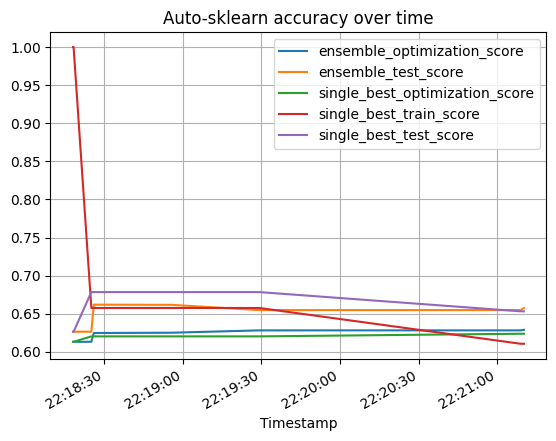

In [18]:
automl.performance_over_time_.plot(
        x='Timestamp',
        kind='line',
        legend=True,
        title='Auto-sklearn accuracy over time',
        grid=True,
    )
plt.show()

# H2O

In [19]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.20.1" 2023-08-24; OpenJDK Runtime Environment (build 11.0.20.1+1-post-Ubuntu-0ubuntu122.04); OpenJDK 64-Bit Server VM (build 11.0.20.1+1-post-Ubuntu-0ubuntu122.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.10/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp2eomkkmh
  JVM stdout: /tmp/tmp2eomkkmh/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmp2eomkkmh/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.1
H2O_cluster_version_age:,16 days
H2O_cluster_name:,H2O_from_python_unknownUser_epgp44
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.170 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


In [20]:
h20_train = h2o.import_file('/content/data/df_train.gzip')
h20_valid = h2o.import_file('/content/data/df_valid.gzip')

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [21]:
x = h20_train.columns[:-1]
y = h20_train.columns[-1]

In [22]:
h20_train[y] = h20_train[y].asfactor()
h20_valid[y] = h20_valid[y].asfactor()

In [24]:
aml = H2OAutoML(
    max_models=20,
    max_runtime_secs=200,
    max_runtime_secs_per_model=60,
    stopping_metric='AUC',
    stopping_tolerance=0.02,
    stopping_rounds=5,
    sort_metric='AUC',
    export_checkpoints_dir='/content/h2o_models',
    seed=1)

aml.train(x=x, y=y, training_frame=h20_train)

AutoML progress: |
22:26:47.599: _train param, Dropping bad and constant columns: [acetohexamide_Steady, admission_type_id_4, metformin-rosiglitazone_Steady, miglitol_Up, tolazamide_Up, discharge_disposition_id_10, discharge_disposition_id_12, gender_Unknown/Invalid, troglitazone_Steady, glimepiride-pioglitazone_Steady, admission_source_id_14, admission_source_id_25, payer_code_FR, discharge_disposition_id_17, admission_source_id_13, glipizide-metformin_Steady, admission_source_id_11, admission_source_id_22, glyburide-metformin_Up, admission_type_id_7, metformin-pioglitazone_Steady, chlorpropamide_Up]

████
22:26:59.221: _train param, Dropping bad and constant columns: [acetohexamide_Steady, admission_type_id_4, metformin-rosiglitazone_Steady, miglitol_Up, tolazamide_Up, discharge_disposition_id_10, discharge_disposition_id_12, gender_Unknown/Invalid, troglitazone_Steady, glimepiride-pioglitazone_Steady, admission_source_id_14, admission_source_id_25, payer_code_FR, discharge_dispositi

Model Details
=============
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: GBM_grid_1_AutoML_2_20231101_222647_model_2


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    50                 50                          12205                  4            4            4             9             16            14.82

ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.2178639189487019
RMSE: 0.46675895165352954
LogLoss: 0.625414530266741
Mean Per-Class Error: 0.4050989455271539
AUC: 0.7105706529810722
AUCPR: 0.7191512385932138
Gini: 0.4211413059621445

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.37774436585308213
       0     1     Error    Rate
-----  ----  ----  -------  ----------------
0      1601  3899  0.7089   (3899.0/5500.0)
1      558   4951  0.1013   (558.0/5509.0)
Total  2159  8850  0.4049   (4457.0/11009.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.377744     0.689602  311
max f2                       0.289265     0.835011  373
max f0point5                 0.537457     0.656417  185
max accuracy                 0.467063     0.651558  236
max precision                0.909844     1         0
max recall                   0.250201     1         390
max specificity              0.909844     1         0
max absolute_mcc             0.543401     0.310648  181
max min_per_class_accuracy   0.473378     0.649636  231
max mean_per_class_accuracy  0.467063     0.651543  236
max tns                      0.909844     5500      0
max fns                      0.909844     5508      0
max fps                      0.203948     5500      399
max tps                      0.250201     5509      390
max tnr                      0.909844     1         0
max fnr                      0.909844     0.999818  0
max fpr                      0.203948     1         399
max tpr                      0.250201     1         390

Gains/Lift Table: Avg response rate: 50.04 %, avg score: 50.09 %
group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.0100827                   0.819609           1.98036   1.98036            0.990991         0.842014  0.990991                    0.842014            0.0199673       0.0199673                  98.0363   98.0363            0.0197855
2        0.0200745                   0.798234           1.9257    1.95315            0.963636         0.807568  0.977376                    0.824869            0.0192412       0.0392086                  92.5698   95.3154            0.0382995
3        0.0300663                   0.780885           1.83486   1.91384            0.918182         0.788302  0.957704                    0.812717            0.0183336       0.0575422                  83.4864   91.3843            0.0549967
4        0.0400581                   0.767982           1.74403   1.87149            0.872727         0.77386   0.936508                    0.803025            0.017426        0.0749682                  74.4029   87.1486            0.0698773
5        0.05005                     0.754139           1.65319   1.82791            0.827273         0.761064  0.914701                

# Leaderboard

> Leaderboard shows models with their metrics. When provided with H2OAutoML object, the leaderboard shows 5-fold cross-validated metrics by default (depending on the H2OAutoML settings), otherwise it shows metrics computed on the frame. At most 20 models are shown by default.

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse,training_time_ms,predict_time_per_row_ms,algo
GBM_2_AutoML_2_20231101_222647,0.664712,0.65024,0.210563,0.383046,0.477351,0.227864,2459,0.009198,GBM
GBM_grid_1_AutoML_2_20231101_222647_model_2,0.66373,0.650568,0.209631,0.38139,0.477781,0.228274,1505,0.012576,GBM
GBM_5_AutoML_2_20231101_222647,0.663635,0.649129,0.209662,0.384742,0.476802,0.22734,3627,0.008668,GBM
GBM_4_AutoML_2_20231101_222647,0.661296,0.659168,0.205523,0.383298,0.481009,0.231369,3614,0.01419,GBM
GBM_3_AutoML_2_20231101_222647,0.660174,0.652277,0.211798,0.383008,0.478197,0.228673,3763,0.014832,GBM
GLM_1_AutoML_2_20231101_222647,0.658884,0.654579,0.212985,0.39644,0.478106,0.228586,1515,0.003167,GLM
XGBoost_3_AutoML_2_20231101_222647,0.6578,0.656666,0.205269,0.38439,0.479881,0.230286,2366,0.005407,XGBoost
GBM_1_AutoML_2_20231101_222647,0.657232,0.654122,0.205679,0.387064,0.479803,0.230211,4893,0.011632,GBM
DRF_1_AutoML_2_20231101_222647,0.65488,0.657051,0.194676,0.396077,0.481505,0.231847,5410,0.01772,DRF
XGBoost_grid_1_AutoML_2_20231101_222647_model_3,0.648957,0.663267,0.200193,0.398544,0.48266,0.23296,2360,0.005186,XGBoost


# Confusion Matrix

> Confusion matrix shows a predicted class vs an actual class.

## GBM_grid_1_AutoML_2_20231101_222647_model_2

,0,1,Error,Rate
0,9998.0,3218.0,0.2435,(3218.0/13216.0)
1,875.0,810.0,0.5193,(875.0/1685.0)
Total,10873.0,4028.0,0.2747,(4093.0/14901.0)


# Learning Curve Plot

> Learning curve plot shows the loss function/metric dependent on number of iterations or trees for tree-based algorithms. This plot can be useful for determining whether the model overfits.

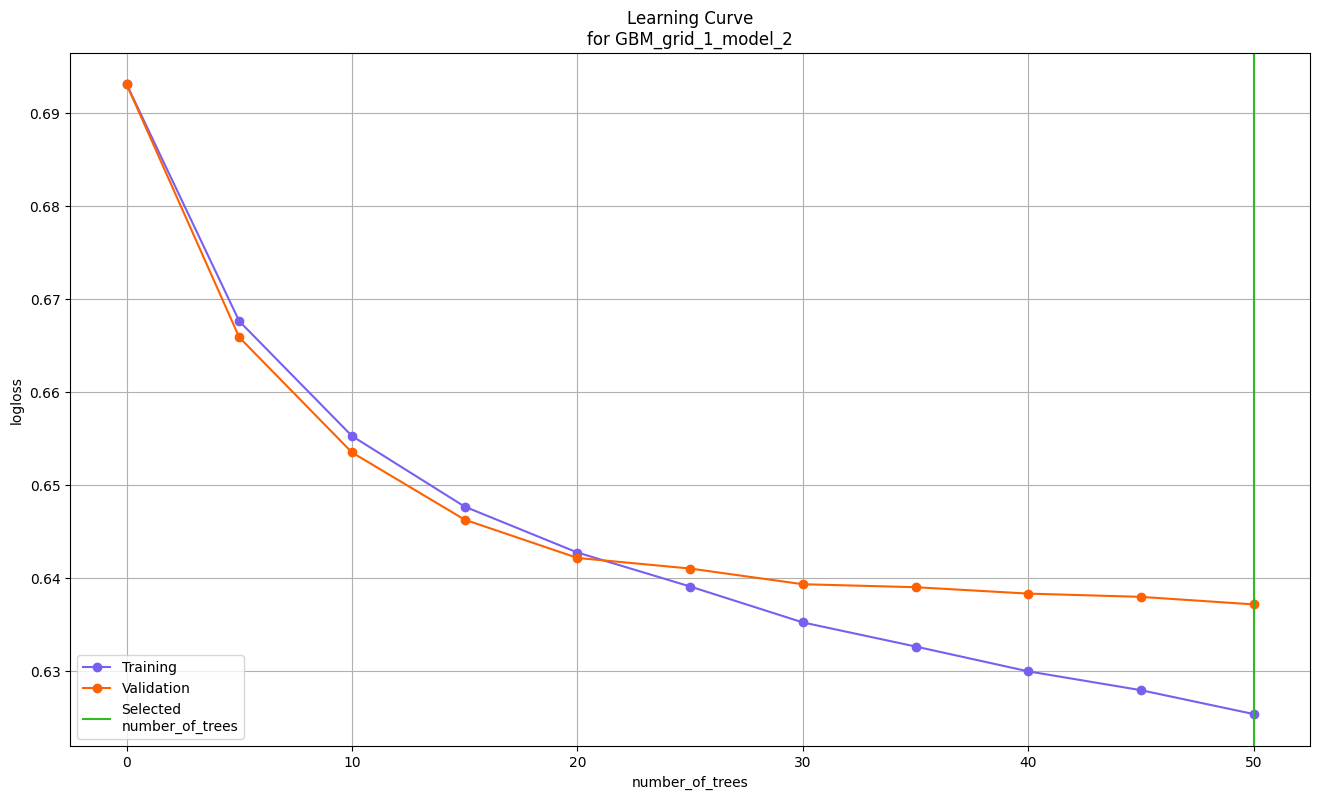

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

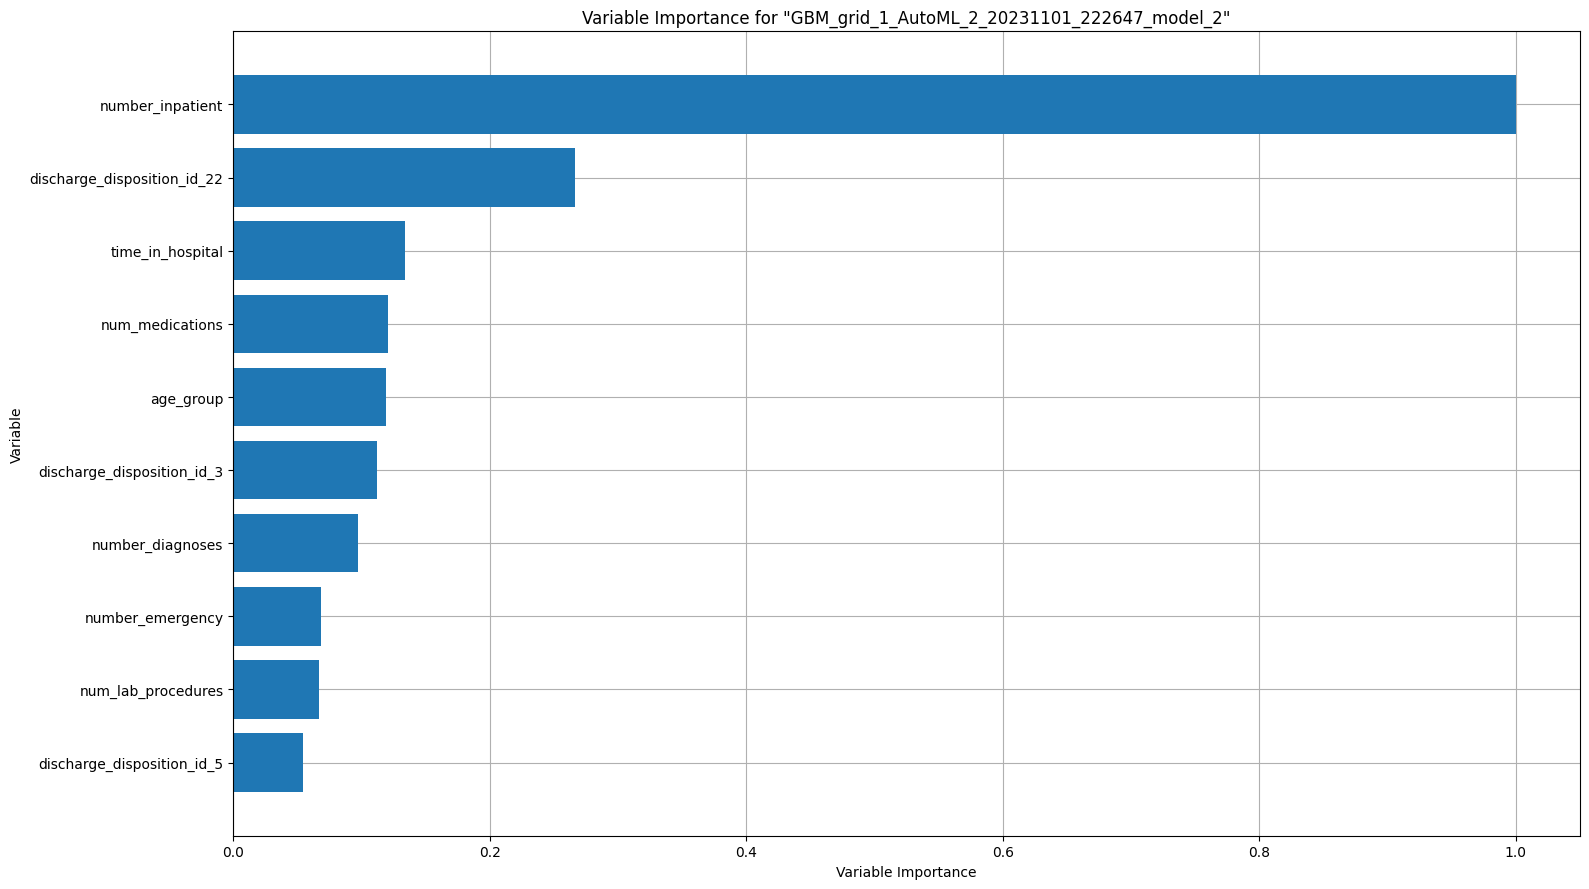

# Variable Importance Heatmap

> Variable importance heatmap shows variable importance across multiple models. Some models in H2O return variable importance for one-hot (binary indicator) encoded versions of categorical columns (e.g. Deep Learning, XGBoost). In order for the variable importance of categorical columns to be compared across all model types we compute a summarization of the the variable importance across all one-hot encoded features and return a single variable importance for the original categorical feature. By default, the models and variables are ordered by their similarity.

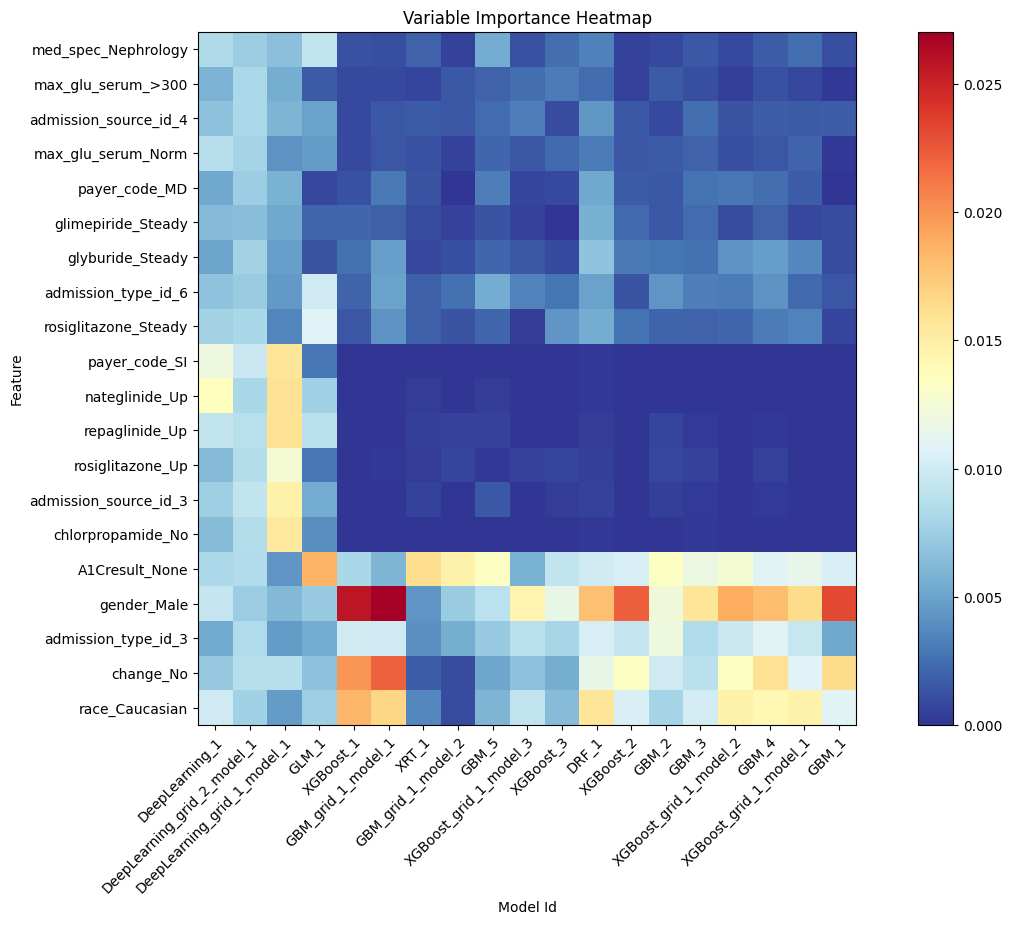

# Model Correlation

> This plot shows the correlation between the predictions of the models. For classification, frequency of identical predictions is used. By default, models are ordered by their similarity (as computed by hierarchical clustering). Interpretable models, such as GAM, GLM, and RuleFit are highlighted using red colored text.

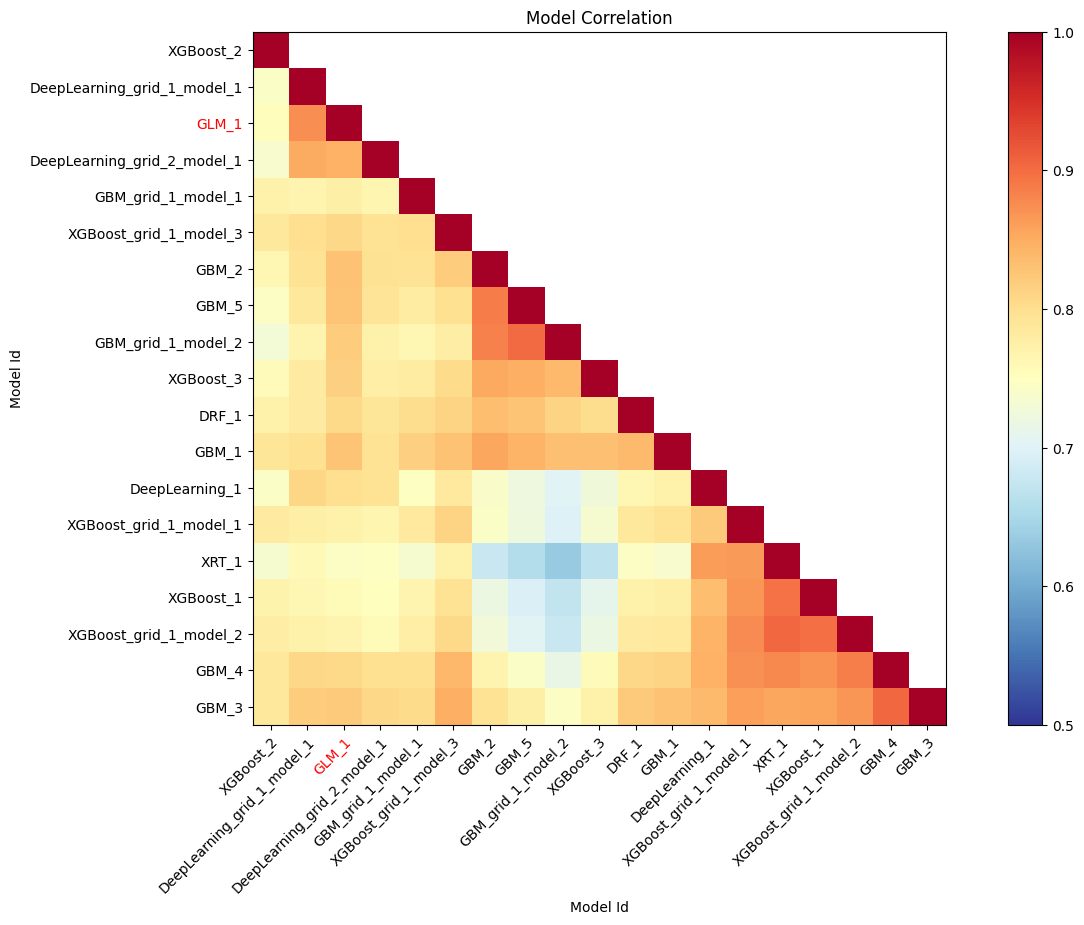

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

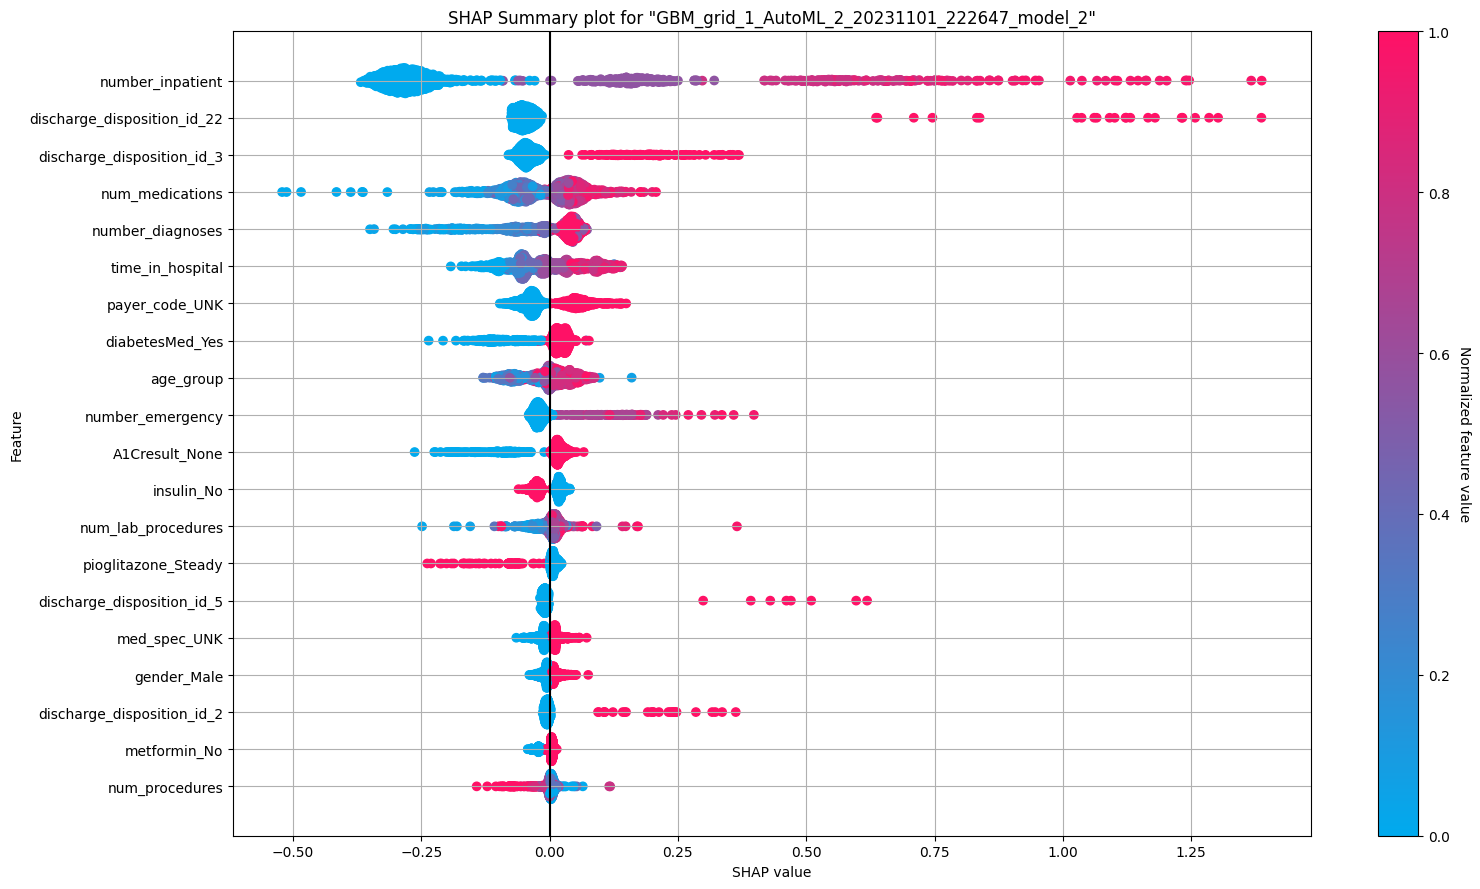

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

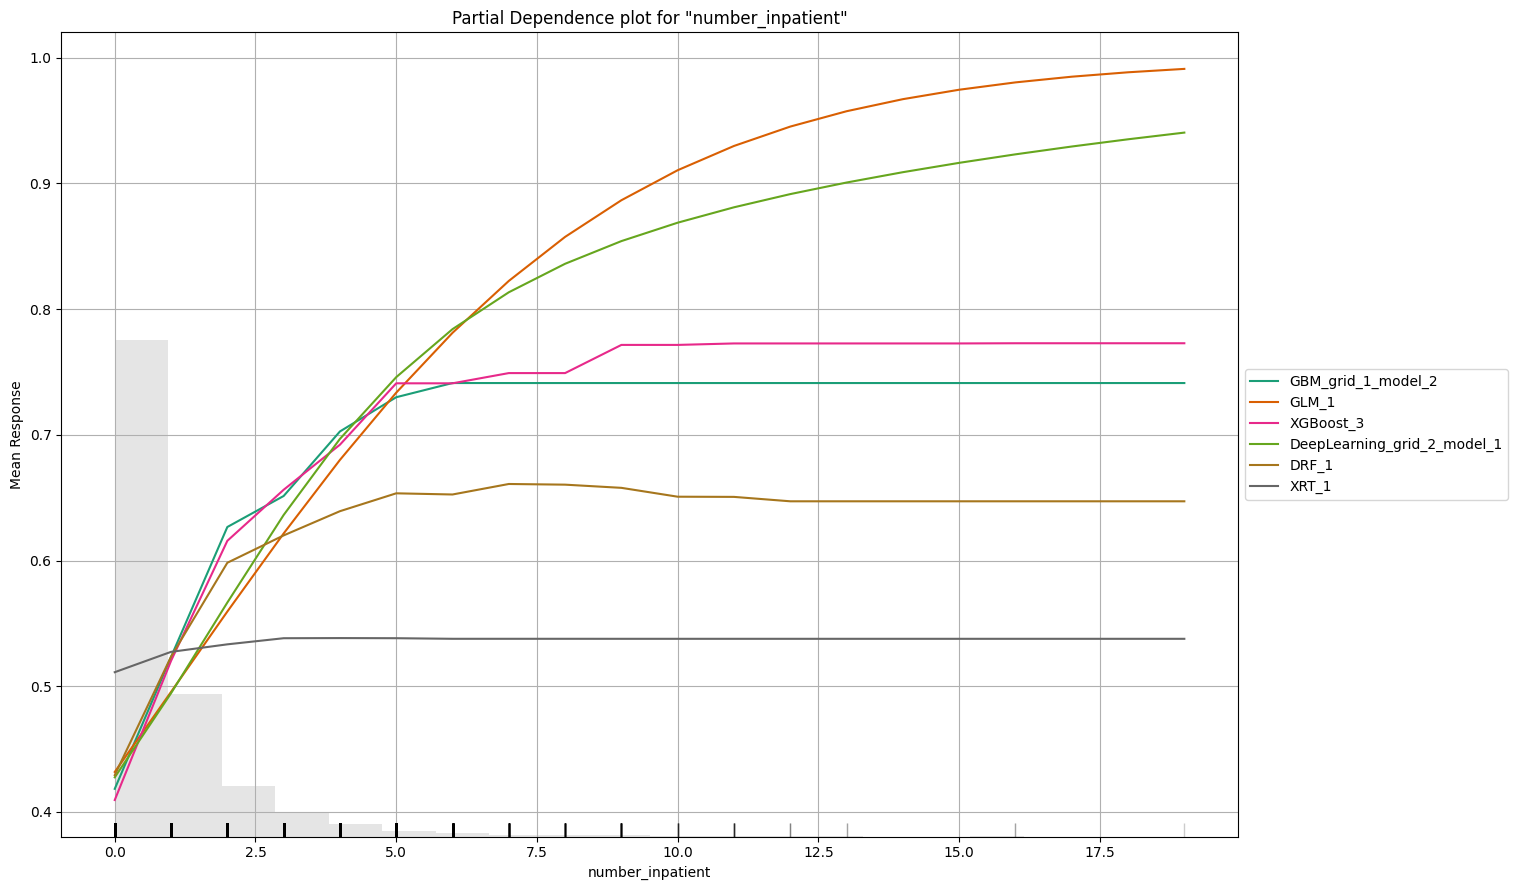

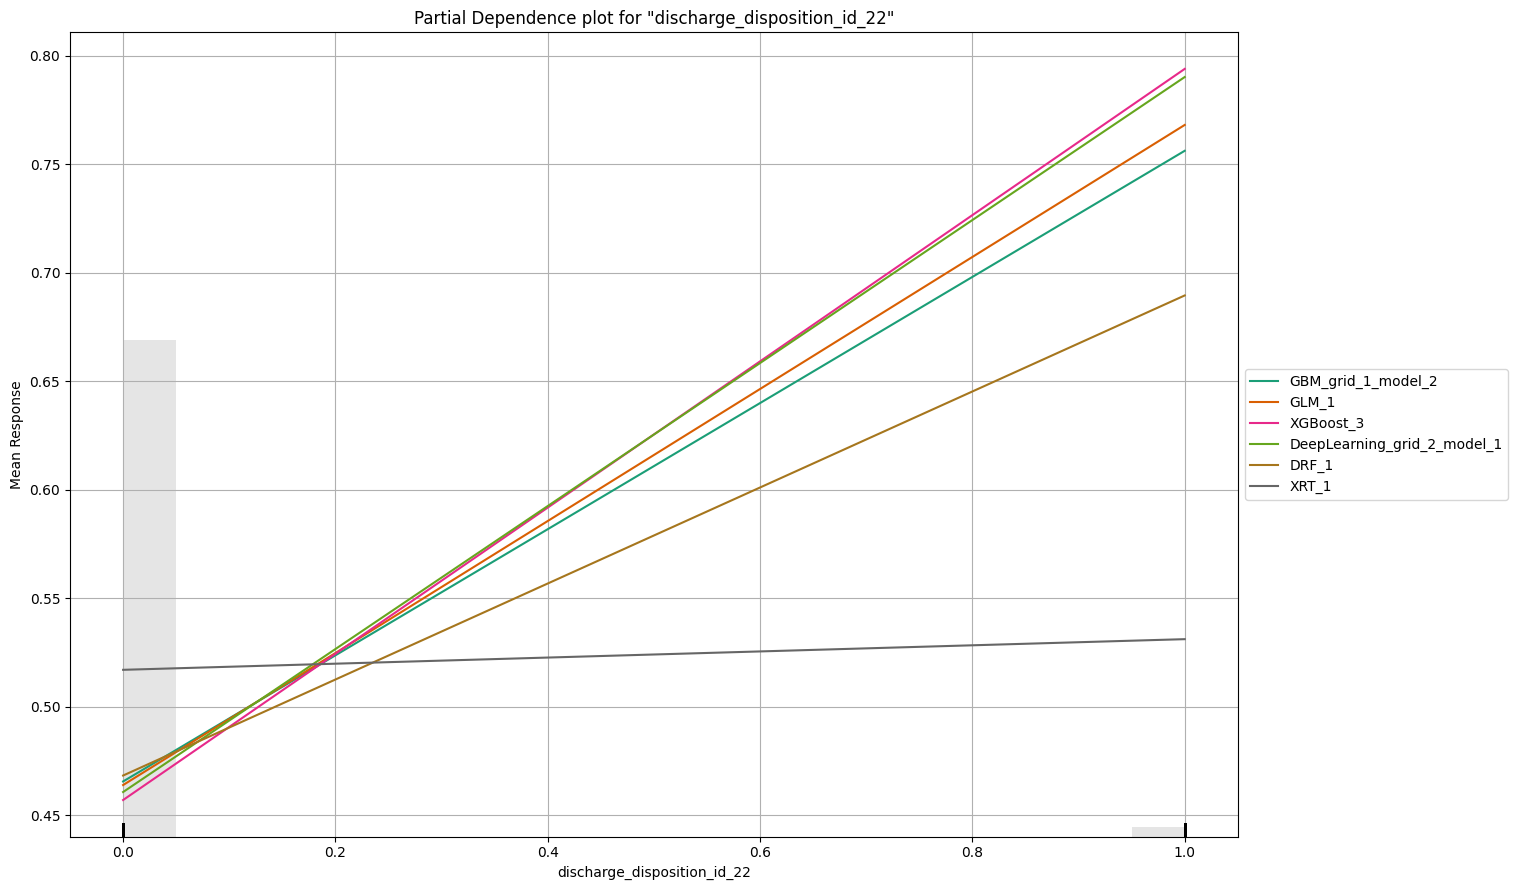

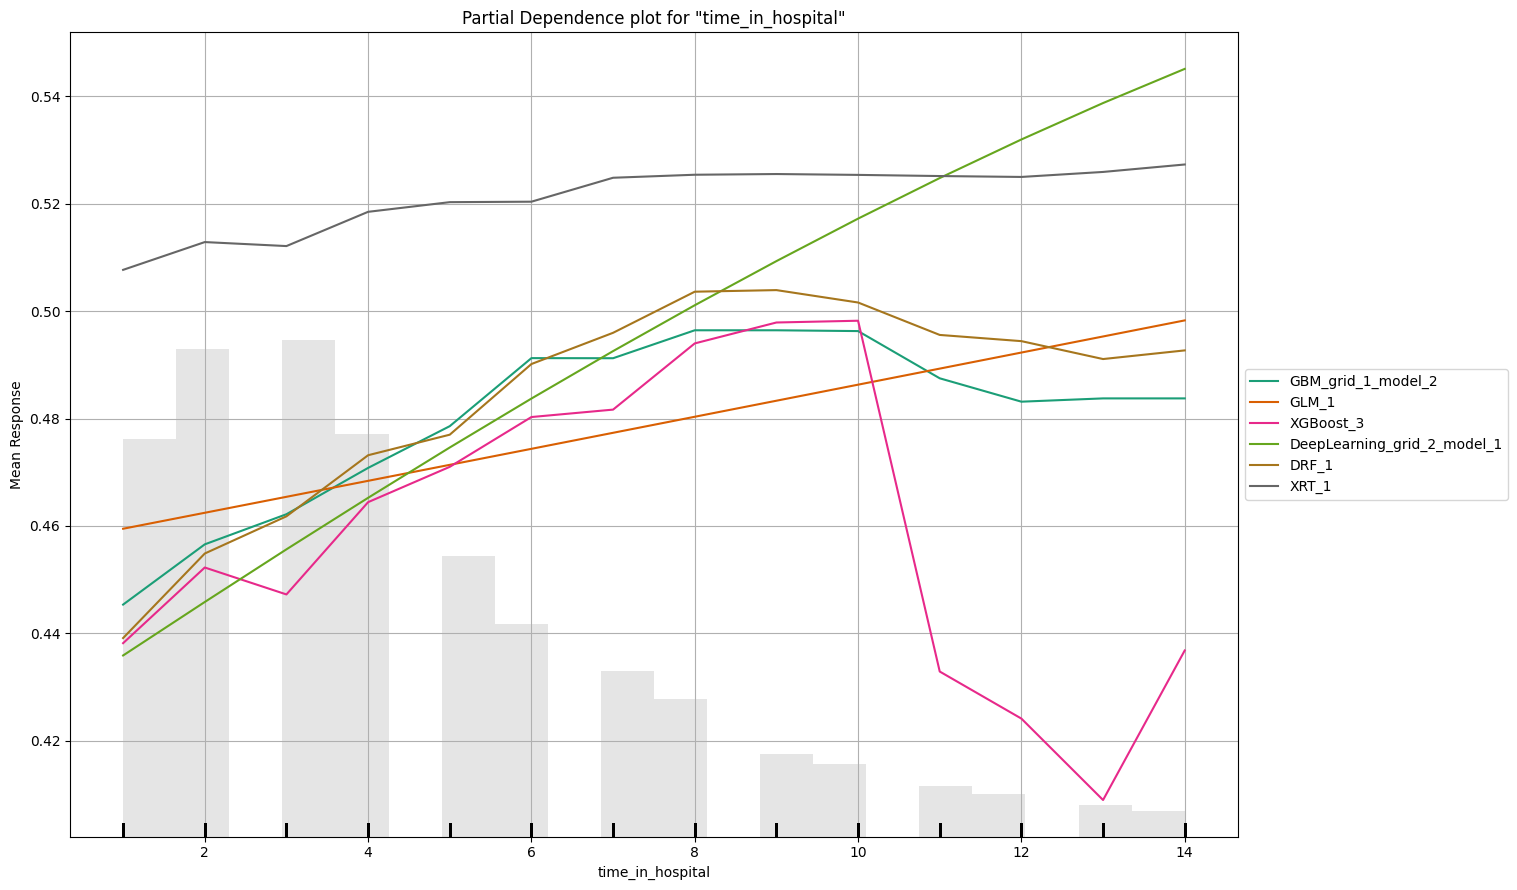

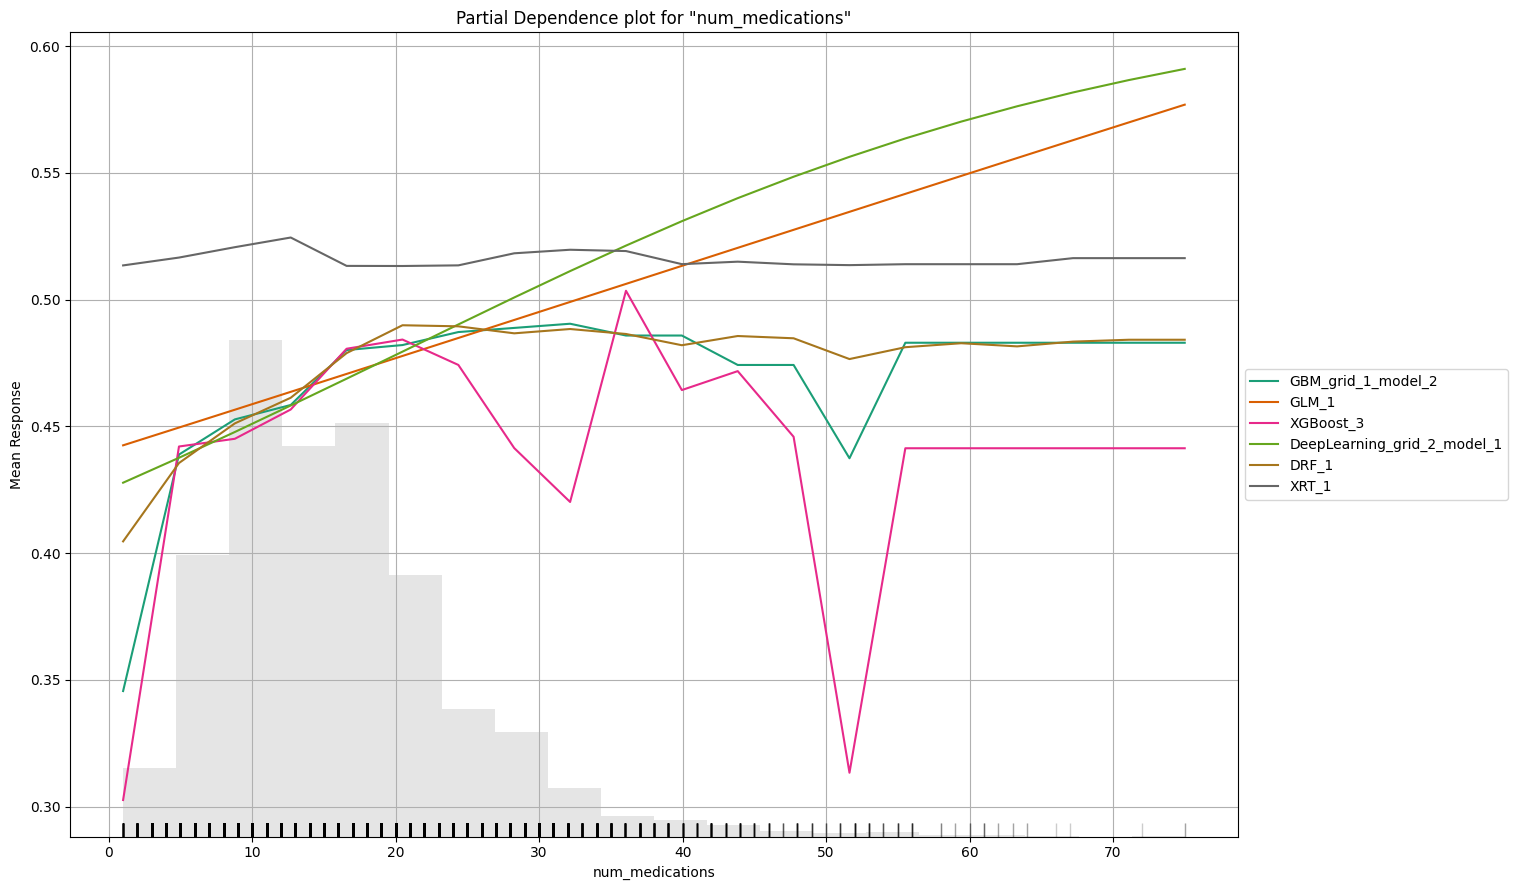

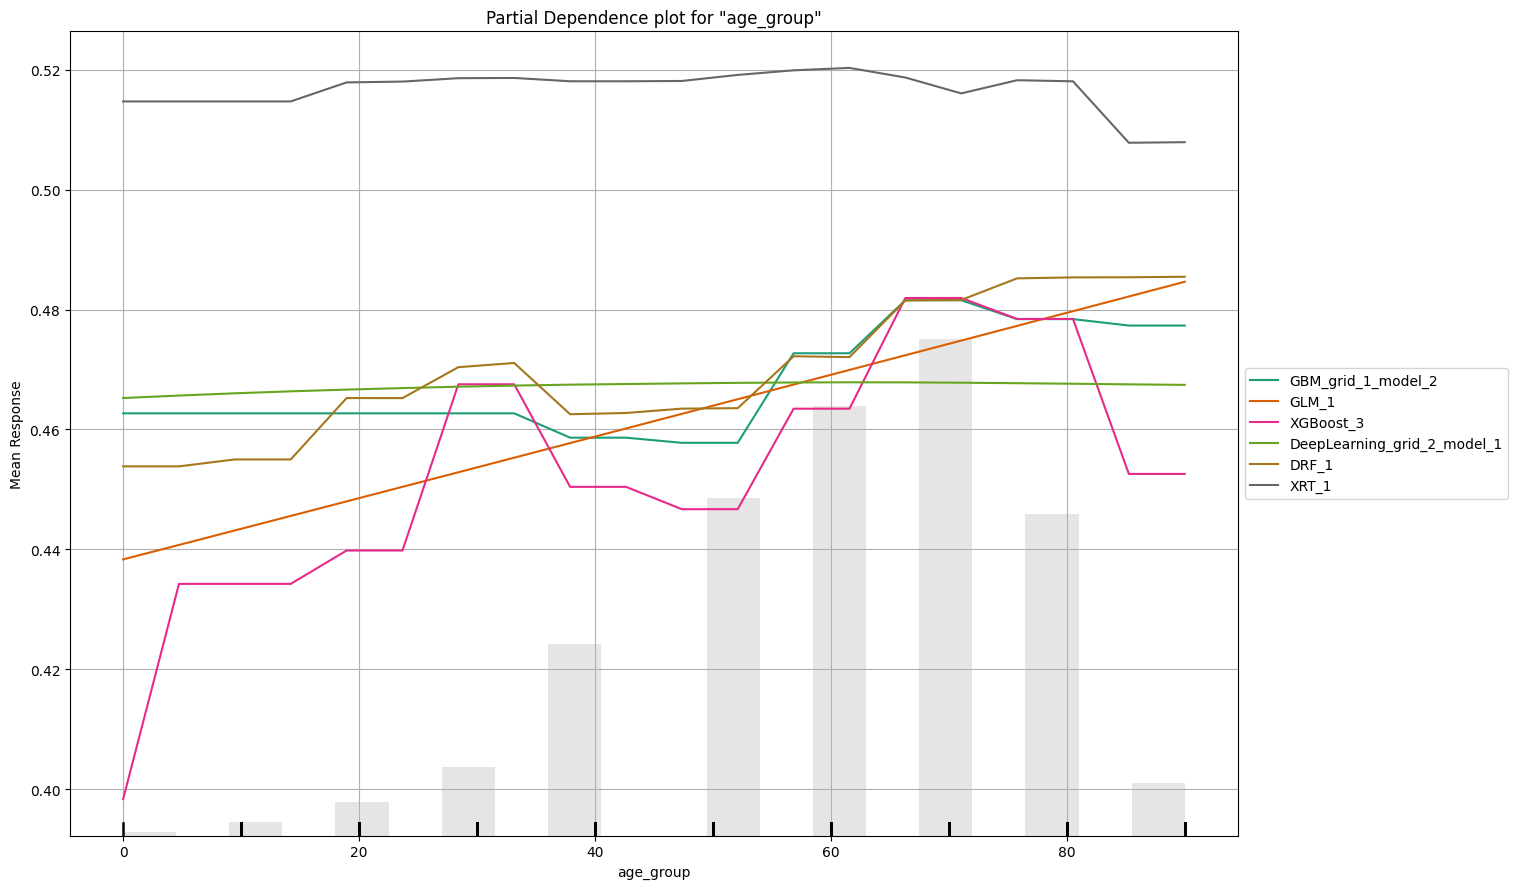

In [25]:
exm = aml.explain(h20_valid)